In [270]:
import os, sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

# to get deterministic output
torch.manual_seed(123)

sys.path.append(os.path.abspath(".."))

### Loading the Dataset

In [271]:
df = pd.read_csv("../datasets/perceptron_toydata-truncated.txt", sep="\t")
df

,x1,x2,label
0,0.77,-1.14,0
1,-0.33,1.44,0
2,0.91,-3.07,0
3,-0.37,-1.91,0
4,-0.63,-1.53,0
5,0.39,-1.99,0
6,-0.49,-2.74,0
7,-0.68,-1.52,0
8,-0.10,-3.43,0
9,-0.05,-1.95,0


In [272]:
X_train = df[["x1", "x2"]].values
y_train = df["label"].values

print("Train set:", X_train.shape, y_train.shape)

Train set: (20, 2) (20,)


### Data Preprocessing

In [273]:
# scaling for better convergence
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [274]:
print("Training labels:")
counts = Counter(y_train)
for key, value in counts.items():
    print(f"{key}: {value}")

Training labels:
0: 10
1: 10


### Visualize the Dataset

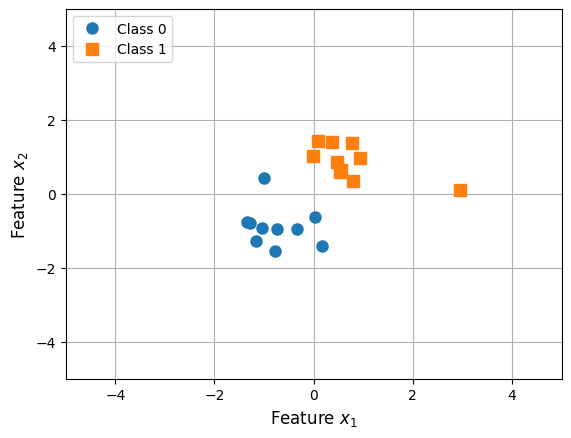

In [275]:
from modules.plotting_helper import plot_feature2d
plot_feature2d(X_train, y_train, markersize=8)

### Define the DataLoader

In [276]:
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.features = torch.tensor(X, dtype=torch.float32)
        self.labels = torch.tensor(y, dtype=torch.float32)

    def __getitem__(self, index):
        x = self.features[index]
        y = self.labels[index]        
        return x, y

    def __len__(self):
        return self.labels.shape[0]

train_ds = MyDataset(X_train, y_train)
train_loader = DataLoader(dataset=train_ds, batch_size=10, shuffle=True)

### Design the Model

In [277]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim):
        super().__init__()        
        self.linear = torch.nn.Linear(input_dim, 1) # single output
    
    def forward(self, x):
        logits = self.linear(x)
        return torch.sigmoid(logits)

### Train the model

In [278]:
def train(model, optimizer, num_epochs):
    history = []
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        model = model.train()        
        for X_batch, y_batch in train_loader:
            # forward pass
            y_pred = model(X_batch)
            loss = F.binary_cross_entropy(y_pred, y_batch.view(y_pred.shape))
            
            # backward pass
            optimizer.zero_grad()
            loss.backward()        
            optimizer.step()
            
            epoch_loss += abs(loss)
        history.append(epoch_loss)
        print(f'Epoch: {epoch+1:03d}/{num_epochs:03d}'
              f' | train_loss: {epoch_loss:.2f}')
    return history
  
          
model = LogisticRegression(X_train.shape[1])
optimizer = torch.optim.SGD(model.parameters(), lr=0.05) # Stochastic gradient descent
history = train(model, optimizer, num_epochs=20)

Epoch: 001/020 | train_loss: 1.61
Epoch: 002/020 | train_loss: 1.53
Epoch: 003/020 | train_loss: 1.46
Epoch: 004/020 | train_loss: 1.38
Epoch: 005/020 | train_loss: 1.32
Epoch: 006/020 | train_loss: 1.26
Epoch: 007/020 | train_loss: 1.20
Epoch: 008/020 | train_loss: 1.15
Epoch: 009/020 | train_loss: 1.11
Epoch: 010/020 | train_loss: 1.06
Epoch: 011/020 | train_loss: 1.02
Epoch: 012/020 | train_loss: 0.98
Epoch: 013/020 | train_loss: 0.94
Epoch: 014/020 | train_loss: 0.91
Epoch: 015/020 | train_loss: 0.88
Epoch: 016/020 | train_loss: 0.85
Epoch: 017/020 | train_loss: 0.82
Epoch: 018/020 | train_loss: 0.79
Epoch: 019/020 | train_loss: 0.77
Epoch: 020/020 | train_loss: 0.74


In [279]:
bias = model.linear.bias[0].data.numpy()
weights = model.linear.weight[0].data.numpy()
print("Bias:", bias)
print("Weights:", weights)

Bias: -0.22059093
Weights: [0.33994535 0.70471394]


### Evaluate the Model

In [280]:
def predict(model, X):
    model = model.eval()
    with torch.inference_mode():
            return model(X)

In [ ]:
predictions = predict(model, train_ds.features)     
y_preds = (predictions >= 0.5).float()

train_acc = accuracy_score(train_ds.labels, y_preds)
print(f"Train Accuracy: {train_acc:.2f}")

cmat = confusion_matrix(train_ds.labels, y_preds)
print("Confusion Matrix:")
print(cmat)

Train Accuracy: 1.00
Confusion Matrix:
[[10  0]
 [ 0 10]]


### Vizualize the Results

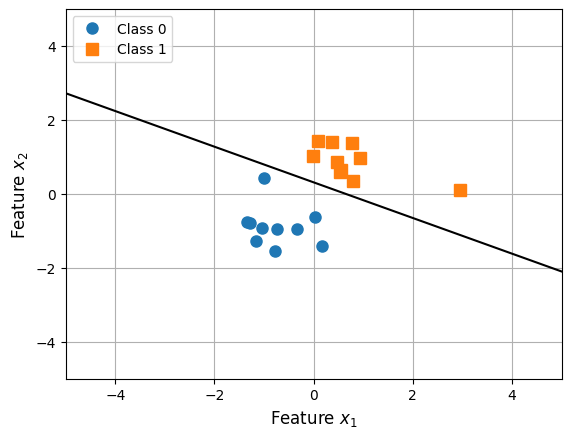

In [282]:
plot_feature2d(X_train, y_train, bias, weights, markersize=8)